In [1]:
import time
import math
from fenics import *
import dolfin as dl
import ufl
import numpy as np
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib.pyplot as plt
import argparse
import itertools as iter
import sys
import os
from hippylib import *
import tqdm

# Parse command line arguments for parallel computing
sep = "\n"+"#"*80+"\n"
ndim = 2
s = 0.5

# Noise parameter and output settings
sigma = np.sqrt(3.9e-3)
out_dir = "output/"
t_init = 0.
t_final = 10.
tlist = np.linspace(0, 10, 100)

parRandom = Random(seed=np.random.randint(0,1000))


# Define tumor growth equation using finite element variational formulation
class TumorEquationVarf:
    def __init__(self, dt, dx, D):
        self._dt = dt
        self.dt_inv = dl.Constant(1./dt)
        self.dx = dx
        self.D = D

    @property
    def dt(self):
        return self._dt

    def __call__(self,u,u_old, m, p, t):
        return (u - u_old)*p*self.dt_inv*self.dx \
               + ufl.exp(self.D)*ufl.inner(ufl.grad(u), ufl.grad(p))*self.dx \
               - ufl.exp(m)*u*(dl.Constant(1.) - u)*p*self.dx \

# Load mesh and boundary/subdomain information
mesh = dl.Mesh("mesh/W05_0.xml")
boundaries = dl.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(2)
sub_domains = dl.MeshFunction("size_t", mesh, mesh.topology().dim())
with dl.XDMFFile("data/W05_brain.xdmf") as fid:
    fid.read(sub_domains)
    
# Set up finite element function spaces
P1 = dl.FiniteElement("Lagrange", cell=mesh.ufl_cell(), degree=1)
P2 = dl.FiniteElement("Lagrange", cell=mesh.ufl_cell(), degree=1)
Vh2 = dl.FunctionSpace(mesh, P2)
Vh1 = dl.FunctionSpace(mesh, P1)

# Function spaces for [STATE, PARAMETER, ADJOINT]
Vh = [Vh2, Vh1, Vh2]
ndofs = [Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()]
print (sep, "Set up the mesh and finite element spaces", sep)
print ("Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs) )
f = dl.Constant(0.0)
bc = []; bc0 = []


################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=14003, PARAMETER=14003, ADJOINT=14003


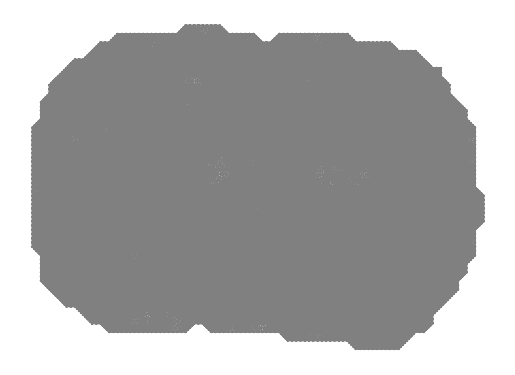

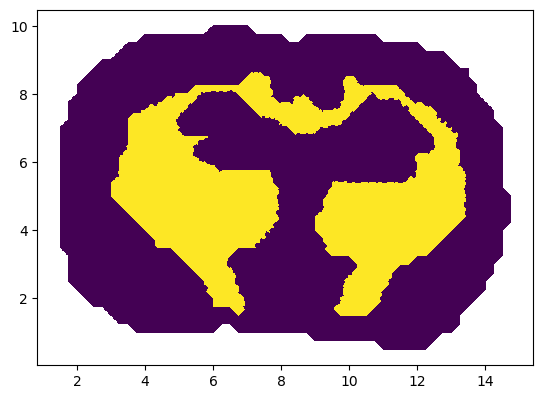

In [2]:
nb.plot(mesh)
plt.figure()
plot(sub_domains)

In [3]:
# Physical parameters for gray matter (gm) and white matter (wm)
# Gray matter diffusion parameters
rho_gm_D = 6 
var_gm_D =  0.2336 
DELTA_gm_D = np.sqrt(2)/(np.sqrt(var_gm_D)*rho_gm_D*np.sqrt(np.pi))
GAMMA_gm_D = rho_gm_D/(np.sqrt(var_gm_D)*4*np.sqrt(2*np.pi))
mean_gm_D = -0.9937

# Gray matter growth parameters
rho_gm_G = 6 
var_gm_G =  0.0682
DELTA_gm_G = np.sqrt(2)/(np.sqrt(var_gm_G)*rho_gm_G*np.sqrt(np.pi))
GAMMA_gm_G = rho_gm_G/(np.sqrt(var_gm_G)*4*np.sqrt(2*np.pi))
mean_gm_G = -0.78 

# White matter diffusion parameters
rho_wm_D = 12 
var_wm_D =  0.2336
DELTA_wm_D = np.sqrt(2)/(np.sqrt(var_wm_D)*rho_wm_D*np.sqrt(np.pi))
GAMMA_wm_D = rho_wm_D/(np.sqrt(var_wm_D)*4*np.sqrt(2*np.pi))
mean_wm_D = -0.3006 

# White matter growth parameters
rho_wm_G = 12
var_wm_G = 0.0682
DELTA_wm_G = np.sqrt(2)/(np.sqrt(var_wm_G)*rho_wm_G*np.sqrt(np.pi))
GAMMA_wm_G = rho_wm_G/(np.sqrt(var_wm_G)*4*np.sqrt(2*np.pi))
mean_wm_G = -0.8419 



In [5]:
# Brain tissue property class - assigns different values to gray/white matter
class Brain(UserExpression):
    def __init__(self, subdomains, k0, k1, **kwargs):
        super().__init__(**kwargs)
        self.subdomains = subdomains
        self.k0 = k0
        self.k1 = k1
    
    def eval_cell(self, values, x, cell):
        if self.subdomains[cell.index] == 0:
            values[0] = self.k0
    
        if self.subdomains[cell.index] == 1:
            values[0] = self.k1
    
    def value_shape(self):
        return ()

In [6]:
# Create mean diffusion and growth parameter fields
m_0 = Brain(sub_domains, mean_gm_D, mean_wm_D) 
m_mean = interpolate(m_0, Vh1)
g_0 = Brain(sub_domains, mean_gm_G, mean_wm_G) 
g_mean = project(g_0, Vh1)

In [17]:
# Robin boundary condition coefficients
gamma = dl.Constant((GAMMA_gm_G, GAMMA_wm_G))
delta = dl.Constant((DELTA_gm_G, DELTA_wm_G))
def get_robin_coeff(gamma, delta):
    return np.sqrt(delta*gamma)/np.sqrt(np.pi)
robin_coeff = dl.Constant((get_robin_coeff(GAMMA_gm_G, DELTA_gm_G), get_robin_coeff(GAMMA_wm_G, DELTA_wm_G)))

In [19]:
# Define prior distribution for parameters with different tissue types
def vector_sqrt_precision_varf_handler(trial, test): 
    
    dx = Measure('dx', domain=mesh, subdomain_data=sub_domains)
    ds = Measure('ds', domain=mesh, subdomain_data=sub_domains)

    # Gray matter (subdomain 0) contributions
    varfL = ufl.inner(gamma[0] * ufl.grad(trial), ufl.grad(test))*dx(0)
    varfM = ufl.inner(delta[0]*trial,test)*dx(0)
    varf_robin = ufl.inner(robin_coeff[1] * trial,test)*ds(0)
    
    # White matter (subdomain 1) contributions        
    varfL1 = ufl.inner(gamma[1] * ufl.grad(trial), ufl.grad(test))*dx(1)
    varfM1 = ufl.inner(delta[1]*trial,test)*dx(1)
    varf_robin1 = ufl.inner(robin_coeff[1] * trial,test)*ds(1)
    
    return varfL + varfM + varf_robin + varfL1 + varfM1 + varf_robin1

prior = SqrtPrecisionPDE_Prior(Vh[PARAMETER], vector_sqrt_precision_varf_handler, mean=g_mean.vector(), rel_tol=1e-12, max_iter=1000)

In [29]:
dt = 0.1
u0_expr = dl.Expression("std::exp( - pow(pow(x[0]-px, 2)/sigma2x + pow(x[1]-py, 2)/sigma2y, p) )", element = Vh[STATE].ufl_element(), p=4, sigma2x=0.2, sigma2y=0.2, px=9, py=7)
u0 = dl.interpolate(u0_expr, Vh[STATE])

# Set up the PDE problem
pde_varf = TumorEquationVarf(dt, ufl.dx, m_mean)
pde = TimeDependentPDEVariationalProblem(Vh, pde_varf, bc, bc0, u0, t_init, t_final, is_fwd_linear=False)

In [30]:
# Generate true model parameters (noisy sample from prior)
def true_model(prior):
    """Return a noisy sample from the prior.
    """
    noise = dl.Vector()
    prior.init_vector(noise,"noise")
    parRandom.normal(1., noise)
    mtrue = dl.Vector()
    prior.init_vector(mtrue, 0)
    prior.sample(noise,mtrue)
    return mtrue

In [44]:
def tDVec_to_numpy(tdvec):
    times = len(tdvec.times)
    state = tdvec.data[0].size()
    nparray = np.zeros((times,state))
    for i in range(times):
        nparray[i][:] = tdvec.data[i].get_local()
    return nparray

In [ ]:
# Generate PDE solutions
for i in range(50):
    utrue = pde.generate_state()
    atrue = pde.generate_adjoint()

    ## Prior sample
    mtrue = true_model(prior)  

    x = [utrue, mtrue, atrue]

    ## Solve Forward problem
    pde.solveFwd(x[STATE], x)
    intmed = tDVec_to_numpy(x[STATE])
    ulist.append(intmed)
    xlist.append(x)

In [47]:
# Compute PCA using the PDE solutions
ulist_np = np.array(ulist)
xlist_np_ = ulist_np[:,1:]
check = ulist_np
check_flat = check.reshape(-1,14003)
cov_matrix = np.cov(check_flat, rowvar=False)

# Eigendecomposition of covariance matrix for PCA
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
eigvals = np.flip(eigenvalues)
eigenvecs = np.flip(eigenvectors,axis=1)

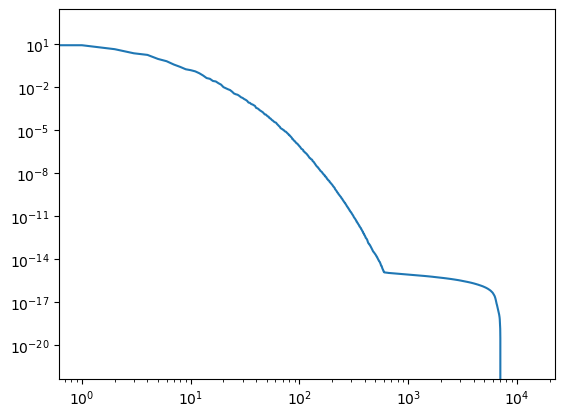

In [62]:
plt.loglog(eigvals)

In [63]:
np.save('PCA_U_f_100',eigenvecs)

In [65]:
# Jacobian transpose times Jacobian operator for computing AS
class JTJ_J:
    def __init__(self, pde, prior, umalist=None, AS=None):
        self.pde = pde
        self.prior = prior
        self.umalist = umalist
        self.AS = AS
        
        # Help function
        self.dm = dl.Vector()
        self.out_ = TimeDependentVector(self.pde.times)
        self.sol_ = TimeDependentVector(self.pde.times)
        self.out_2 = TimeDependentVector(self.pde.times)
        self.help_u_snap = dl.Vector()
        self.help_u_snap1 = dl.Vector()
        self.out_3 = TimeDependentVector(self.pde.times)
        self.sol_2 = TimeDependentVector(self.pde.times)
        self.out_4 = TimeDependentVector(self.pde.times)
        self.out_5 = dl.Vector()
        self.help_vec = dl.Vector()
    
    # Initialize the vectors    
    def init_vec(self):
        self.prior.init_vector(self.dm, 0)
        self.out_.initialize(self.pde.M, 0)
        self.sol_.initialize(self.pde.M, 0)
        self.pde.M.init_vector(self.help_u_snap, 0)
        self.pde.M.init_vector(self.help_u_snap1, 0)
        self.out_3.initialize(self.pde.M, 0)
        self.sol_2.initialize(self.pde.M, 0)
        self.out_4.initialize(self.pde.M, 0)
        self.prior.init_vector(self.out_5, 0)
        self.prior.init_vector(self.help_vec, 0)
    
    def J_fs(self):     
        res = []
        for i in range(len(self.AS)):
            self.init_vec()
            self.dm.set_local(self.AS[i])
            self.pde.applyC(self.dm, self.out_)
            self.pde._solveIncrementalFwd(self.sol_, self.out_)
            intmed = tDVec_to_numpy(self.out_)
            res.append(intmed)
        return np.array(res)
    
    def mult(self, x, y):
        deno = len(self.umalist)
        for i in range(deno):

            self.init_vec()
            # Not include negative because (-1)*(-1)
            self.pde.setLinearizationPoint(self.umalist[i], True)
            self.pde.applyC(x, self.out_)
            self.pde._solveIncrementalFwd(self.sol_, self.out_)
            self.pde._solveIncrementalAdj(self.sol_2, self.sol_)
            self.pde.applyCt(self.sol_2, self.help_vec)
            y.axpy(1./deno, self.help_vec)

In [66]:
# Compute Active Subspace using the PDE solutions
AS_gen = JTJ_J(pde, prior, xlist)
Omega = MultiVector(x[PARAMETER], 128+10)
parRandom.normal(1., Omega)
d, U = doublePassG(AS_gen, prior.R, prior.Rsolver, Omega, 128)

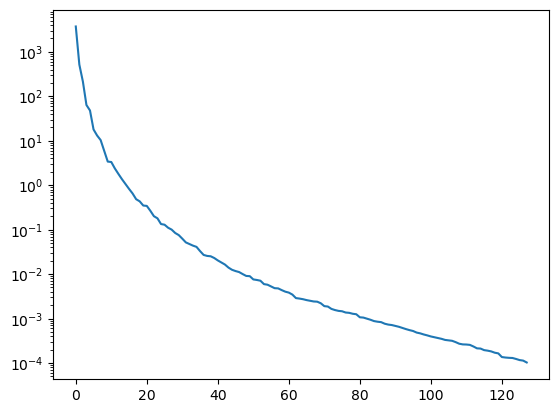

In [ ]:
plt.semilogy(d)

In [ ]:
sub_list = []
for i in range(128):
    sub_list.append(U[i].get_local())
np_sub_list = np.array(sub_list)
np.save('AS_fs', np_sub_list.T)